In [1]:
from scipy import misc
from PIL import Image
from skimage import exposure
from sklearn import svm
import scipy
from math import sqrt,pi
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import glob
import matplotlib.pyplot as pltss
import cv2
from matplotlib import cm
import pandas as pd
from math import pi, sqrt
import pywt

In [2]:
import cv2
import numpy as np

immatrix = []

# Loop over the range from 1 to 130 (inclusive)
for i in range(1, 671):
    # Construct the base path
    img_base_path = "/Users/krutarthyg/Desktop/RP/Diabetes/new/image"

    # Pad the index with zeros to maintain a consistent filename format
    img_index_str = str(i).zfill(3)

    # Construct the full path for the image
    img_path = f"{img_base_path}{img_index_str}.png"

    print("Loading image:", img_path)  # Debugging: Print image path

    # Load the image
    img = cv2.imread(img_path)

    if img is None:
        print(f"Failed to load image: {img_path}")
        continue

    # Display the original image for the 130th image
    if i == 670:
        print("Original image:")
        #cv2.imshow("Original image",img)

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Display grayscale image for the 130th image
    if i == 670:
        print("Grayscale image:")
        #cv2.imshow("Grayscale Image",img_gray)

    # Apply histogram equalization
    equ = cv2.equalizeHist(img_gray)

    # Flatten the 2D array of the equalized image
    immatrix.append(np.array(equ).flatten())

print("Total images processed:", len(immatrix))

Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image001.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image002.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image003.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image004.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image005.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image006.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image007.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image008.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image009.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image010.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image011.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image012.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image013.png
Loading image: /Users/krutarthyg/Desktop/RP/Diabetes/new/image014.png
Loading image: /User

In [3]:
np.shape(np.array(equ).flatten())

(50176,)

In [4]:
np.shape(immatrix)
np.shape(equ)

(224, 224)

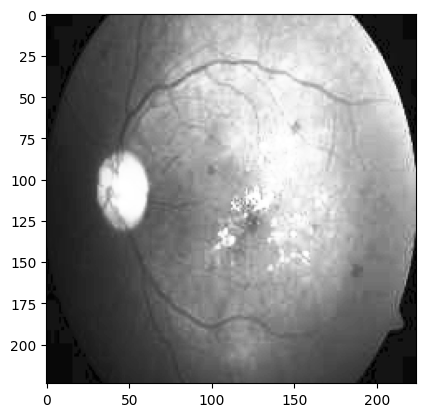

In [5]:
plt.imshow(immatrix[669].reshape((224, 224)),cmap='gray')
plt.show()

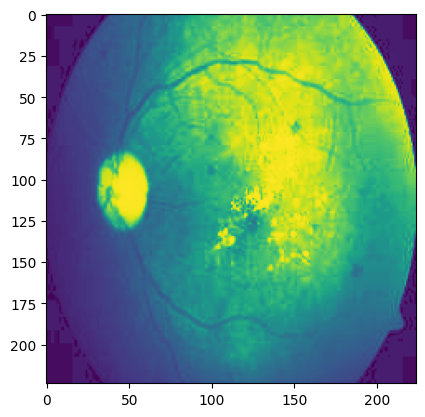

In [6]:
plt.imshow(immatrix[669].reshape((224, 224)))
plt.show()

In [7]:
imm_dwt = []
for equ in immatrix:
    equ = equ.reshape((224, 224))
    coeffs = pywt.dwt2(equ, 'haar')
    equ2 = pywt.idwt2(coeffs, 'haar')
    imm_dwt.append(np.array(equ2).flatten())

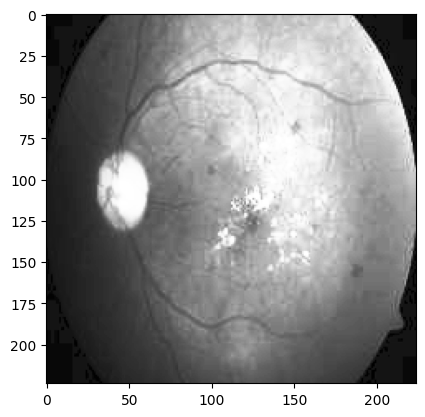

In [8]:
np.shape(imm_dwt)
np.shape(equ2)
plt.imshow(imm_dwt[669].reshape((224, 224)),cmap='gray')
plt.show()

In [9]:
def _filter_kernel_mf_fdog(L, sigma, t = 3, mf = True):
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an unnatural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    #@vectorize(['float32(float32)'], target='cpu')
    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1) 

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image, cmap = cm.Greys_r)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()


def gaussian_matched_filter_kernel(L, sigma, t = 3):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    return _filter_kernel_mf_fdog(L, sigma, t, True)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]

    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    return kernels

#Given a filter bank, apply them and record maximum response

def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)


gf = gaussian_matched_filter_kernel(20, 5)
bank_gf = createMatchedFilterBank(gf, 4)

imm_gauss = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((224, 224))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss.append(np.array(equ3).flatten())


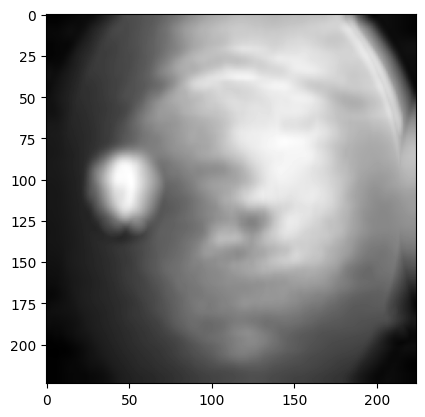

In [10]:
# the array ranges from 0-89
np.shape(imm_gauss)
plt.imshow(imm_gauss[669].reshape((224, 224)),cmap='gray')
plt.show()

In [11]:
def createMatchedFilterBank():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters

def applyFilters(im, kernels):
    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

bank_gf = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss2 = []
for equ2 in imm_dwt:
    equ2 = equ2.reshape((224, 224))
    equ3 = applyFilters(equ2,bank_gf)
    imm_gauss2.append(np.array(equ3).flatten())


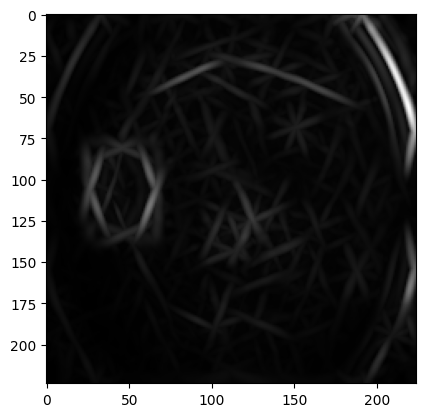

In [12]:
# the array ranges from 0-89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[669].reshape((224, 224)),cmap='gray')
plt.show()

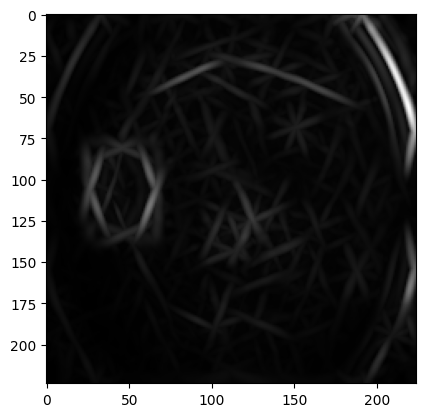

In [13]:
# the array ranges from 0-89
np.shape(imm_gauss2)
plt.imshow(imm_gauss2[669].reshape((224, 224)),cmap='gray')
plt.show()

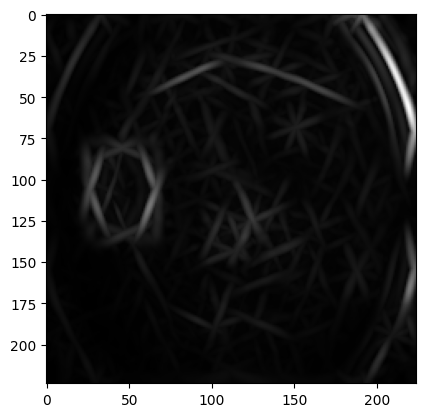

In [14]:
e_ = equ3
np.shape(e_)
#=e_.reshape((-1,3))
#np.shape(e_)
e_reshaped = e_.reshape((224, 224))
plt.imshow(e_reshaped, cmap='gray')
plt.show()

In [15]:
img = equ3
img_reshaped = img.reshape((224, 224))

# convert to np.float32
Z = np.float32(img_reshaped)

# reshape into a single channel
Z = Z.reshape((-1, 1))

k = cv2.KMEANS_PP_CENTERS

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, k)

# Now convert back into uint8, and make the original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))


In [16]:
imm_kmean = []
for equ3 in imm_gauss2:
    img = equ3.reshape((224, 224))
    Z = img.reshape((-1, 1))  # reshape into a single channel

    # convert to np.float32
    Z = np.float32(Z)

    k = cv2.KMEANS_PP_CENTERS

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, k)

    # Now convert back into uint8, and make the original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())


In [17]:
imm_kmean

[array([87, 87, 87, ..., 87, 87, 87], dtype=uint8),
 array([228, 228, 228, ..., 228, 228, 228], dtype=uint8),
 array([128, 128, 128, ..., 128, 128, 128], dtype=uint8),
 array([170, 170, 170, ..., 170, 170, 170], dtype=uint8),
 array([70, 70, 70, ..., 70, 70, 70], dtype=uint8),
 array([211, 211, 211, ..., 211, 211, 211], dtype=uint8),
 array([145, 145, 145, ..., 145, 145, 145], dtype=uint8),
 array([39, 39, 39, ..., 39, 39, 39], dtype=uint8),
 array([131, 131, 131, ..., 131, 131, 131], dtype=uint8),
 array([207, 207, 207, ..., 207, 207, 207], dtype=uint8),
 array([142, 142, 142, ..., 142, 142, 142], dtype=uint8),
 array([198, 198, 198, ..., 198, 198, 198], dtype=uint8),
 array([202, 202, 202, ..., 202, 202, 202], dtype=uint8),
 array([187, 187, 187, ..., 187, 187, 187], dtype=uint8),
 array([145, 145, 145, ..., 145, 145, 145], dtype=uint8),
 array([101, 101, 101, ..., 101, 101, 101], dtype=uint8),
 array([40, 40, 40, ..., 40, 40, 40], dtype=uint8),
 array([154, 154, 154, ..., 154, 154, 

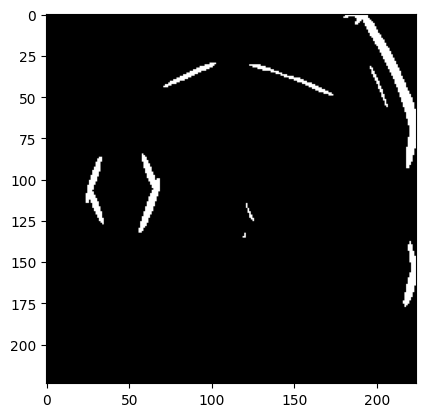

In [18]:
# the array ranges from 0-89
np.shape(imm_kmean)
plt.imshow(imm_kmean[669].reshape((224, 224)),cmap="gray")
plt.show()

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [20]:
Y = np.ones(670)
Y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [21]:
Y[0]=Y[8]=Y[19]=Y[25]=Y[28]=Y[40]=Y[45]=Y[49]=Y[55]=Y[63]=Y[69]=Y[75]=Y[84]=Y[90]=Y[95]=0

In [22]:
Y

array([0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [23]:
k = [1,3,4,9,10,11,13,14,20,22,24,25,26,27,28,29,35,36,38,42,53,55,57,64,70,79,84,86,92]

In [24]:
k = k-np.ones(len(k))

In [25]:
k

array([ 0.,  2.,  3.,  8.,  9., 10., 12., 13., 19., 21., 23., 24., 25.,
       26., 27., 28., 34., 35., 37., 41., 52., 54., 56., 63., 69., 78.,
       83., 85., 91.])

In [26]:
k =[int(x) for x in k]

In [27]:
k

[0,
 2,
 3,
 8,
 9,
 10,
 12,
 13,
 19,
 21,
 23,
 24,
 25,
 26,
 27,
 28,
 34,
 35,
 37,
 41,
 52,
 54,
 56,
 63,
 69,
 78,
 83,
 85,
 91]

In [28]:
imm_train = []
y_train = []
for i in k:
    imm_train.append(imm_kmean[i])
    y_train.append(Y[i])

In [29]:
y_train

[0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [30]:
clf = SVC()

In [31]:
clf.fit(imm_train, y_train)

SVC()

In [32]:
y_pred = clf.predict(imm_kmean)

In [33]:
accuracy_score(Y,y_pred-1)

0.022388059701492536

In [34]:
print(classification_report(Y, y_pred, digits=6))

              precision    recall  f1-score   support

         0.0   0.000000  0.000000  0.000000        15
         1.0   0.977612  1.000000  0.988679       655

    accuracy                       0.977612       670
   macro avg   0.488806  0.500000  0.494340       670
weighted avg   0.955725  0.977612  0.966545       670



/opt/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [35]:
# Print out confusion matrix
cmat = confusion_matrix(Y, y_pred)
print(cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

[[  0  15]
 [  0 655]]
TP - True Negative 0
FP - False Positive 15
FN - False Negative 0
TP - True Positive 655
Accuracy Rate: 0.9776119402985075
Misclassification Rate: 0.022388059701492536


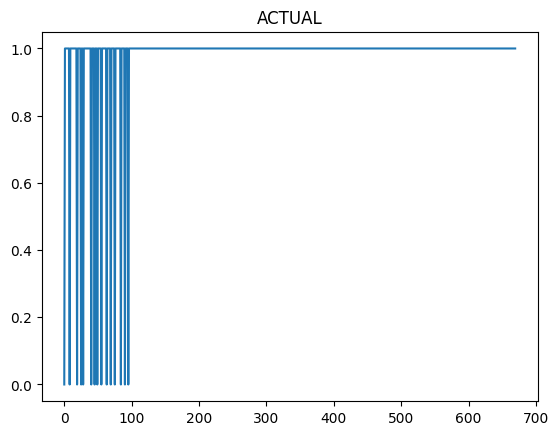

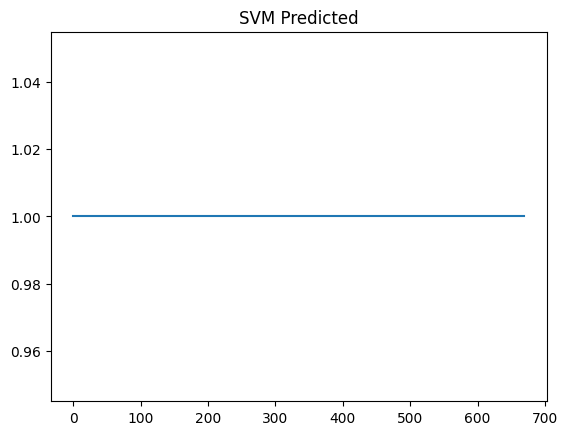

In [36]:
import matplotlib.pyplot as plt
plt.plot(Y)
plt.title("ACTUAL")
plt.show()
plt.plot(y_pred)

plt.title("SVM Predicted")
plt.show()

In [37]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(imm_train, y_train) 
y_pred2=neigh.predict(imm_kmean)
y_pred2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [38]:
accuracy_score(Y,y_pred2)

0.9776119402985075

In [39]:
print(classification_report(Y, y_pred2, digits=6))

              precision    recall  f1-score   support

         0.0   0.000000  0.000000  0.000000        15
         1.0   0.977612  1.000000  0.988679       655

    accuracy                       0.977612       670
   macro avg   0.488806  0.500000  0.494340       670
weighted avg   0.955725  0.977612  0.966545       670



/opt/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/python310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [40]:
# Print out confusion matrix
cmat = confusion_matrix(Y, y_pred2)
print(cmat)
print('TP - True Negative {}'.format(cmat[0,0]))
print('FP - False Positive {}'.format(cmat[0,1]))
print('FN - False Negative {}'.format(cmat[1,0]))
print('TP - True Positive {}'.format(cmat[1,1]))
print('Accuracy Rate: {}'.format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat))))
print('Misclassification Rate: {}'.format(np.divide(np.sum([cmat[0,1],cmat[1,0]]),np.sum(cmat))))

[[  0  15]
 [  0 655]]
TP - True Negative 0
FP - False Positive 15
FN - False Negative 0
TP - True Positive 655
Accuracy Rate: 0.9776119402985075
Misclassification Rate: 0.022388059701492536


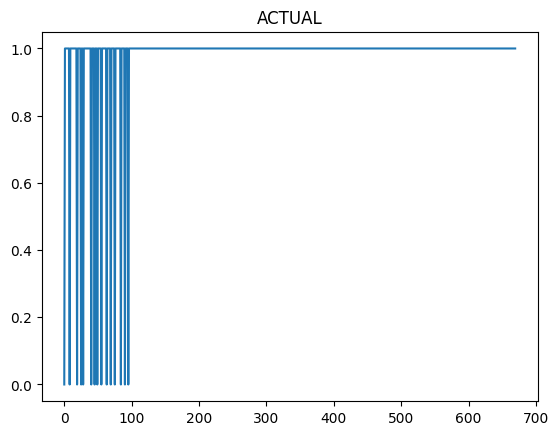

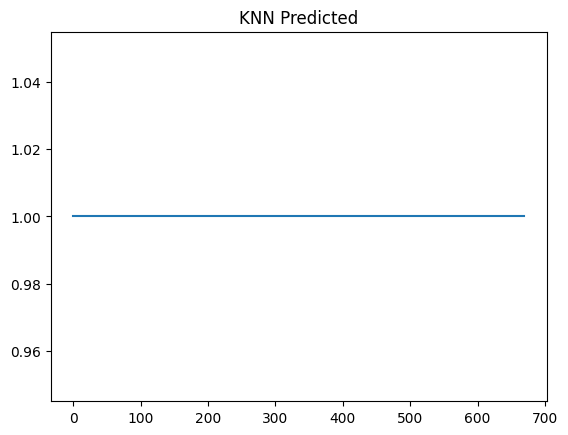

In [41]:
import matplotlib.pyplot as plt
plt.plot(Y)
plt.title("ACTUAL")
plt.show()
plt.plot(y_pred2)
plt.title("KNN Predicted")
plt.show()

Original image is : 
Grayscale image is : 


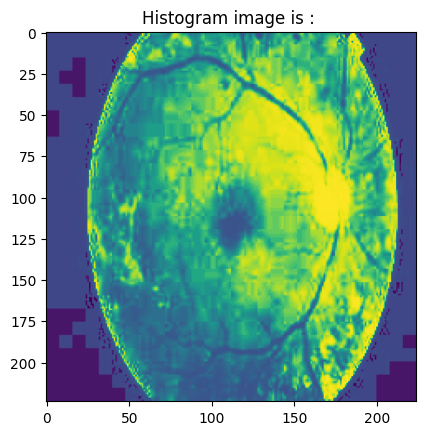

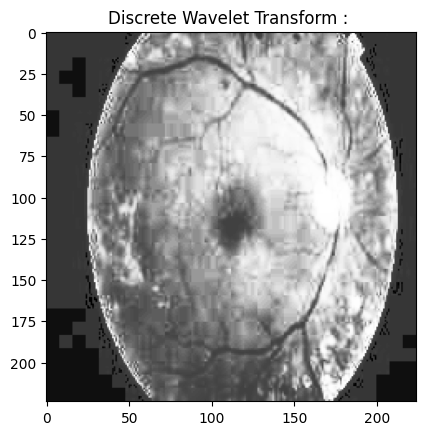

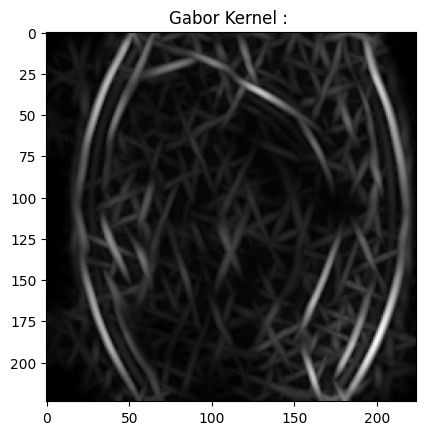

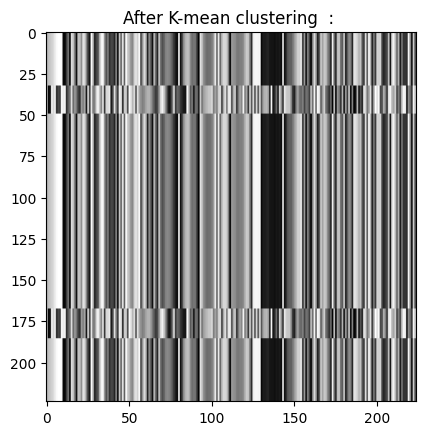

imm_kmean is : 


[array([174, 191, 200, ...,  10, 203,  80], dtype=uint8)]

In [50]:
immatrix1=[]
img_pt1 = "/Users/krutarthyg/Desktop/RP/Diabetes/new/image001.png"
img1 = cv2.imread(img_pt1)
print("Original image is : ")
imS = cv2.resize(img1,(224, 224))  
cv2.imshow("Original image",imS)
img_gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
print("Grayscale image is : ")
imS = cv2.resize(img_gray1, (224,224))  
cv2.imshow("Grayscale image",imS)
equ1 = cv2.equalizeHist(img_gray1) 
immatrix1.append(np.array(equ1).flatten())
plt.title("Histogram image is : ")
plt.imshow(immatrix1[0].reshape(224, 224))
plt.show()
imm_dwt1 = []
for equ1 in immatrix1:
    equ1 = equ1.reshape((224, 224))
    coeffs1 = pywt.dwt2(equ1, 'haar')
    equ21 = pywt.idwt2(coeffs1, 'haar')
    imm_dwt1.append(np.array(equ21).flatten())
plt.title("Discrete Wavelet Transform : ")
plt.imshow(imm_dwt1[0].reshape((224, 224)),cmap='gray')
plt.show()

gf1 = gaussian_matched_filter_kernel(20, 5)
bank_gf1 = createMatchedFilterBank()



imm_gauss1 = []
for equ21 in imm_dwt1:
    equ21 = equ21.reshape((224, 224))
    equ31 = applyFilters(equ21,bank_gf1)
    imm_gauss1.append(np.array(equ31).flatten())
bank_gf1 = createMatchedFilterBank()
#equx=equ3
#equ3 = applyFilters(equ2,bank_gf)
imm_gauss21 = []
for equ21 in imm_dwt1:
    equ21 = equ21.reshape((224, 224))
    equ31 = applyFilters(equ21,bank_gf1)
    imm_gauss21.append(np.array(equ31).flatten())

plt.title("Gabor Kernel : ")
np.shape(imm_gauss21)
plt.imshow(imm_gauss21[0].reshape((224, 224)),cmap='gray')
plt.show()

e_ = equ31
np.shape(e_)
e_=e_.reshape((-1,224))
np.shape(e_)
img = equ31
Z = img.reshape((-1,224))

# convert to np.float32
Z = np.float32(Z)

k=cv2.KMEANS_PP_CENTERS


# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
imm_kmean = []
for equ3 in imm_gauss21:
    img = equ3.reshape((224, 224))
    Z = img.reshape((-1, 224))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    imm_kmean.append(np.array(res2).flatten())

np.shape(imm_kmean)
plt.title("After K-mean clustering  : ")
plt.imshow(imm_kmean[0].reshape((224, 224)),cmap="gray")
plt.show()
print("imm_kmean is : ")
imm_kmean


In [46]:
y_pred = clf.predict(imm_kmean)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [47]:
if y_pred[0] == '0.':
  print("Non- Diabetic")
else:
  print("Diabetic")

Diabetic
